# ⚠️ DS-05: Escenarios de Riesgo en la Cadena de Suministro (LATAM, USD)

Simulación de disrupciones (lead time, proveedor, rutas) y comparación de estrategias de resiliencia con métricas de servicio e inventario.

---
id: "DS-05"
title: "Supply Risk Scenarios"
specialty: "Data Science"
process: "Plan/Source/Deliver"
level: "Intermediate"
tags: ["risk","resilience","latam","inventory","multisourcing"]
estimated_time_min: 50
---

## 📋 Contexto de Negocio

Evaluar resiliencia de la cadena en LATAM considerando:
- Disrupciones típicas: aumento de lead time, caída de proveedor, bloqueo de ruta.
- Impacto en servicio (Fill Rate/OTD) e inventario (SS, cobertura).
- Comparación de estrategias: multi-sourcing, stock de contingencia, re-routing.

Todas las métricas económicas se expresan en USD para comparabilidad.

## 🔧 Instalación de Librerías

```bash
pip install pandas numpy matplotlib seaborn pyarrow
```

Datasets/artefactos generados:
- `risk_scenarios.parquet`
- `strategy_comparison.parquet`
- `risk_impacts.png`
- `strategy_comparison.png`

In [1]:
# Configurar entorno del repositorio
import sys
from pathlib import Path
_candidates = [Path.cwd(), *Path.cwd().parents]
_repo_root = None
for _p in _candidates:
    if (_p / 'pyproject.toml').exists() or (_p / 'src').exists():
        _repo_root = _p
        break
if _repo_root is None:
    _repo_root = Path.cwd()
if str(_repo_root) not in sys.path:
    sys.path.insert(0, str(_repo_root))
data_out = _repo_root / 'data' / 'processed' / 'ds05_supply_risk'
data_out.mkdir(parents=True, exist_ok=True)
print(f'✅ Entorno listo: {_repo_root}')
print(f'💾 Salida: {data_out}')

✅ Entorno listo: f:\GitHub\supply-chain-data-notebooks
💾 Salida: f:\GitHub\supply-chain-data-notebooks\data\processed\ds05_supply_risk


In [2]:
# Imports y configuración
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
sns.set(style='whitegrid')

## 📋 Objetivo y Alcance

- Simular disrupciones típicas en LATAM: aumento de lead time, caída de un proveedor, bloqueo de ruta.
- Medir impacto en servicio (OTD/Fill Rate) e inventario (stock requerido, días de cobertura).
- Comparar estrategias de resiliencia: multi-sourcing, stock de contingencia, re-routing.
- Todas las cifras económicas en USD.

### 🎲 Generación de datos base
- 6 proveedores con lead times y variabilidad realistas.
- 5 rutas (lanes) con tiempos de tránsito y riesgos de bloqueo.
- Demanda diaria simulada (Poisson) y precios en USD.

In [3]:
# Datos base de proveedores y rutas
np.random.seed(123)
suppliers = pd.DataFrame({
    'supplier': [f'Prov_{i+1}' for i in range(6)],
    'base_lead_time_days': [8, 12, 15, 10, 18, 9],
    'lt_std_days': [2.0, 3.0, 4.0, 2.5, 5.0, 2.0],
    'unit_cost_usd': [12.5, 11.0, 10.8, 13.2, 9.9, 12.0],
    'on_time_pct': [0.90, 0.88, 0.85, 0.92, 0.80, 0.89]
})
routes = pd.DataFrame({
    'route': [f'Lane_{i+1}' for i in range(5)],
    'transit_days': [5, 7, 6, 9, 8],
    'block_risk_pct': [2, 4, 3, 6, 5]  # riesgo mensual %
})
demand_days = 60
daily_demand = np.random.poisson(lam=120, size=demand_days)
price_usd = 25.0
print(suppliers)
print(routes.head(), daily_demand[:5])

  supplier  base_lead_time_days  lt_std_days  unit_cost_usd  on_time_pct
0   Prov_1                    8          2.0           12.5         0.90
1   Prov_2                   12          3.0           11.0         0.88
2   Prov_3                   15          4.0           10.8         0.85
3   Prov_4                   10          2.5           13.2         0.92
4   Prov_5                   18          5.0            9.9         0.80
5   Prov_6                    9          2.0           12.0         0.89
    route  transit_days  block_risk_pct
0  Lane_1             5               2
1  Lane_2             7               4
2  Lane_3             6               3
3  Lane_4             9               6
4  Lane_5             8               5 [126 111 127 119 115]


### ⚙️ Funciones auxiliares
- Simulación de lead time por proveedor.
- Cálculo de stock de seguridad y días de cobertura.
- KPI de servicio: Fill Rate aproximado por cobertura.

In [4]:
# Funciones auxiliares
def simulate_lead_time(base, std, multiplier=1.0, dropout=False):
    if dropout:
        return np.inf  # caída de proveedor
    lt = np.random.normal(base * multiplier, std)
    return max(1.0, lt)

def safety_stock(daily_demand_mean, lt_days, demand_std_ratio=0.20):
    # SS ~ z * sigma_d * sqrt(LT); aproximación con z=1.65 (95%)
    z = 1.65
    sigma_d = daily_demand_mean * demand_std_ratio
    return z * sigma_d * np.sqrt(max(1.0, lt_days))

def coverage_days(on_hand_units, daily_demand_mean):
    return on_hand_units / max(1.0, daily_demand_mean)

def fill_rate_by_coverage(cov_days, target_days=15):
    # FR ~ min(1, cov_days/target) como proxy simple
    return float(min(1.0, cov_days / target_days))

## 🌪️ Escenarios de riesgo
- `LT+50%`: aumento de lead time 50%.
- `Supplier Dropout`: un proveedor cae (no disponible).
- `Route Block`: bloqueo de ruta con desvío a ruta alternativa (+30% tiempo).

In [5]:
# Simulación de escenarios
daily_mean = float(np.mean(daily_demand))
scenarios = []
for s_idx, s_row in suppliers.iterrows():
    base_lt = s_row['base_lead_time_days']
    std_lt = s_row['lt_std_days']
    # Base
    lt_base = simulate_lead_time(base_lt, std_lt)
    ss_base = safety_stock(daily_mean, lt_base)
    cov_base = coverage_days(ss_base, daily_mean)
    fr_base = fill_rate_by_coverage(cov_base)
    scenarios.append({'scenario':'Base','supplier':s_row['supplier'],'lead_time_days':lt_base,'safety_stock_units':ss_base,'coverage_days':cov_base,'fill_rate':fr_base})
    # LT+50%
    lt_up = simulate_lead_time(base_lt, std_lt, multiplier=1.5)
    ss_up = safety_stock(daily_mean, lt_up)
    cov_up = coverage_days(ss_up, daily_mean)
    fr_up = fill_rate_by_coverage(cov_up)
    scenarios.append({'scenario':'LT+50%','supplier':s_row['supplier'],'lead_time_days':lt_up,'safety_stock_units':ss_up,'coverage_days':cov_up,'fill_rate':fr_up})
    # Supplier Dropout
    lt_drop = simulate_lead_time(base_lt, std_lt, dropout=True)
    ss_drop = np.nan
    cov_drop = 0.0
    fr_drop = 0.0
    scenarios.append({'scenario':'Supplier Dropout','supplier':s_row['supplier'],'lead_time_days':lt_drop,'safety_stock_units':ss_drop,'coverage_days':cov_drop,'fill_rate':fr_drop})

risk_df = pd.DataFrame(scenarios)
risk_df.to_parquet(data_out / 'risk_scenarios.parquet', index=False)
risk_df.head()

,scenario,supplier,lead_time_days,safety_stock_units,coverage_days,fill_rate
0,Base,Prov_1,10.025478,124.985083,1.044880,0.069659
1,LT+50%,Prov_1,12.557482,139.880415,1.169406,0.077960
2,Supplier Dropout,Prov_1,inf,NaN,0.000000,0.000000
3,Base,Prov_2,7.887155,110.857687,0.926775,0.061785
4,LT+50%,Prov_2,17.002574,162.765732,1.360728,0.090715


## 🔀 Estrategias de resiliencia
- `Multi-sourcing`: repartir demanda entre 2 proveedores.
- `Contingency Stock`: aumentar SS +30%.
- `Re-routing`: usar ruta alternativa (+30% tránsito, pero evita bloqueo).

In [6]:
# Comparación de estrategias en escenario LT+50%
strategy_rows = []
# Seleccionar dos proveedores con mejor on_time
top2 = suppliers.sort_values('on_time_pct', ascending=False).head(2)
daily_mean = float(np.mean(daily_demand))
base_lt = suppliers['base_lead_time_days'].mean()
std_lt = suppliers['lt_std_days'].mean()
lt_up = simulate_lead_time(base_lt, std_lt, multiplier=1.5)
# Baseline (LT+50%)
ss_base = safety_stock(daily_mean, lt_up)
cov_base = coverage_days(ss_base, daily_mean)
fr_base = fill_rate_by_coverage(cov_base)
cost_base_usd = ss_base * price_usd
strategy_rows.append({'strategy':'Baseline LT+50%','fill_rate':fr_base,'ss_units':ss_base,'ss_cost_usd':cost_base_usd})
# Multi-sourcing: combinar lead time promedio ponderado
w = np.array([0.6, 0.4])
lt_ms = np.dot(w, top2['base_lead_time_days']) * 1.2  # ligera penalización de coordinación
ss_ms = safety_stock(daily_mean, lt_ms)
cov_ms = coverage_days(ss_ms, daily_mean)
fr_ms = fill_rate_by_coverage(cov_ms)
cost_ms_usd = ss_ms * price_usd
strategy_rows.append({'strategy':'Multi-sourcing','fill_rate':fr_ms,'ss_units':ss_ms,'ss_cost_usd':cost_ms_usd})
# Contingency Stock: +30% SS
ss_cs = ss_base * 1.3
cov_cs = coverage_days(ss_cs, daily_mean)
fr_cs = fill_rate_by_coverage(cov_cs)
cost_cs_usd = ss_cs * price_usd
strategy_rows.append({'strategy':'Contingency Stock +30%','fill_rate':fr_cs,'ss_units':ss_cs,'ss_cost_usd':cost_cs_usd})
# Re-routing: +30% tránsito promedio
lt_rr = lt_up * 1.30
ss_rr = safety_stock(daily_mean, lt_rr)
cov_rr = coverage_days(ss_rr, daily_mean)
fr_rr = fill_rate_by_coverage(cov_rr)
cost_rr_usd = ss_rr * price_usd
strategy_rows.append({'strategy':'Re-routing +30%','fill_rate':fr_rr,'ss_units':ss_rr,'ss_cost_usd':cost_rr_usd})

strategy_df = pd.DataFrame(strategy_rows)
strategy_df.to_parquet(data_out / 'strategy_comparison.parquet', index=False)
strategy_df

,strategy,fill_rate,ss_units,ss_cost_usd
0,Baseline LT+50%,0.099621,178.744443,4468.611064
1,Multi-sourcing,0.073098,131.156607,3278.915171
2,Contingency Stock +30%,0.129507,232.367775,5809.194383
3,Re-routing +30%,0.113585,203.800021,5095.000520


### 📈 Visualizaciones
- Impacto en Fill Rate y costo de SS (USD).

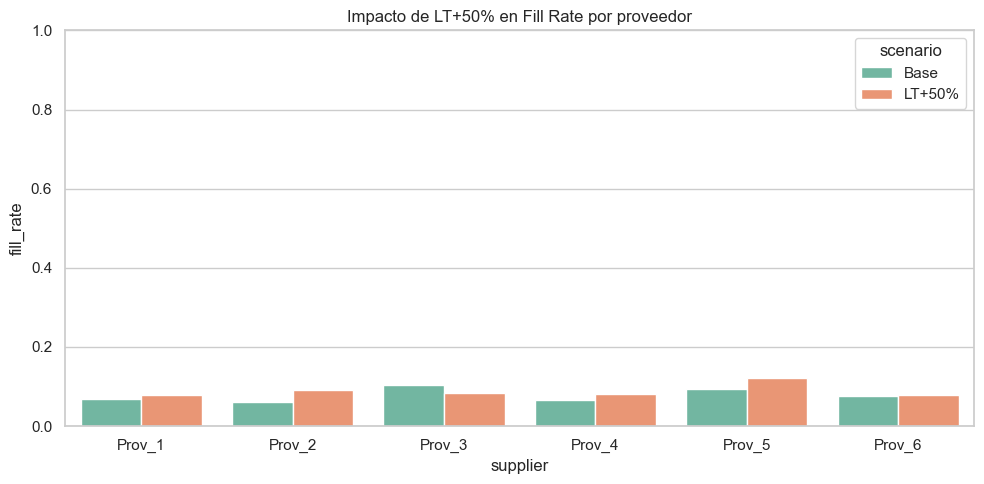

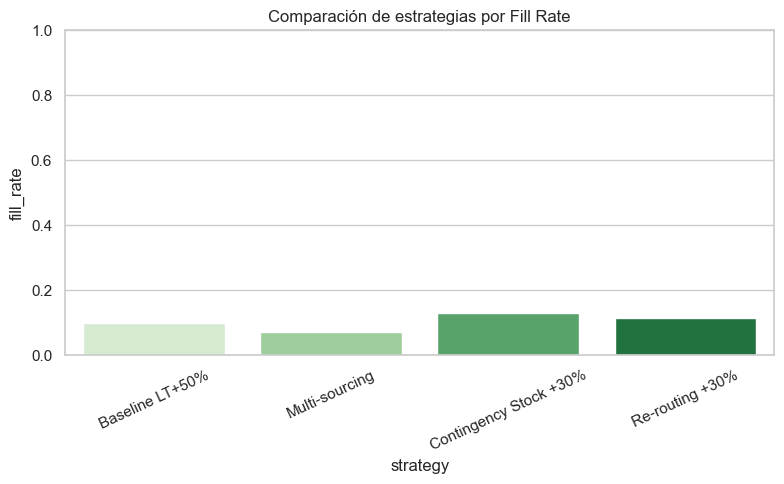

✅ Visualizaciones exportadas a f:\GitHub\supply-chain-data-notebooks\data\processed\ds05_supply_risk


In [7]:
# Graficar impactos
plt.figure(figsize=(10,5))
sns.barplot(data=risk_df[risk_df['scenario'].isin(['Base','LT+50%'])], x='supplier', y='fill_rate', hue='scenario', palette='Set2')
plt.title('Impacto de LT+50% en Fill Rate por proveedor')
plt.ylim(0,1)
plt.tight_layout()
plt.savefig(data_out / 'risk_impacts.png', dpi=150)
plt.show()

plt.figure(figsize=(8,5))
sns.barplot(data=strategy_df, x='strategy', y='fill_rate', palette='Greens')
plt.title('Comparación de estrategias por Fill Rate')
plt.ylim(0,1)
plt.xticks(rotation=25)
plt.tight_layout()
plt.savefig(data_out / 'strategy_comparison.png', dpi=150)
plt.show()
print(f'✅ Visualizaciones exportadas a {data_out}')

## ✅ Validación
- Archivos exportados existen.
- Métricas en rangos razonables (0≤Fill Rate≤1).

In [8]:
# Validación final
import os
for f in ['risk_scenarios.parquet','strategy_comparison.parquet','risk_impacts.png','strategy_comparison.png']:
    assert (data_out / f).exists(), f'Missing: {f}'
    print(f'✅ {f} exists')
assert risk_df['fill_rate'].between(0,1).all(), 'Fill Rate out of bounds'
assert strategy_df['fill_rate'].between(0,1).all(), 'Fill Rate out of bounds (strategies)'
print('🎉 Notebook DS-05 ejecutado y validado')

✅ risk_scenarios.parquet exists
✅ strategy_comparison.parquet exists
✅ risk_impacts.png exists
✅ strategy_comparison.png exists
🎉 Notebook DS-05 ejecutado y validado


## 🧭 Recomendaciones
- En escenarios de LT+50%, `Contingency Stock +30%` mejora FR rápidamente (trade-off costo).
- `Multi-sourcing` estabiliza servicio con coordinación moderada; evaluar contratos y capacidad.
- `Re-routing` aplica cuando el bloqueo de ruta es frecuente; considerar costos adicionales y aduanas.
- Priorizar proveedores con mayor `on_time_pct` y lead time estable para LATAM.

## 📘 Explicaciones Técnicas y Supuestos

- Modelado de demanda: Poisson por día, típico en reposición continua; media ≈ 120 unidades/día.
- Lead time: Normal con media y desviación específicos por proveedor; en disrupciones aplicamos multiplicadores (p.ej., +50%).
- Caída de proveedor: Se modela como `lead_time = ∞` y `fill_rate = 0` para ese origen.
- Bloqueo de ruta: No se simula evento estocástico, sino un proxy determinista (+30% tránsito) para sensibilidad.

**Stock de seguridad (SS):**
- Aproximación: `SS = z * σ_d * sqrt(LT)` con `z=1.65` (≈95% servicio) y `σ_d = mean_demand * 0.20` como ratio de variabilidad.
- Justificación: Fórmula clásica para demanda y lead time aleatorios con independencia y reposición continua.

**Cobertura y Fill Rate (proxy):**
- Cobertura: `coverage_days = SS / mean_daily_demand`.
- Proxy de servicio: `fill_rate ≈ min(1, coverage_days / target_days)` con `target_days = 15`.
- Limitación: Es una aproximación heurística; para precisión usar CSL/FR de modelos (p.ej., base normal, nivel de servicio).

**Estrategias y racionales:**
- Multi-sourcing: Promedia tiempos (penalización 20% por coordinación). Reduce riesgo idiosincrático; implica contratos y logística.
- Contingency stock: Aumenta SS +30% para amortiguar shocks; mejora servicio con costo de capital/almacenaje (USD).
- Re-routing: Desvía por rutas alternativas (+30% tránsito); útil ante bloqueos frecuentes; considerar costos y tiempos aduaneros LATAM.

**Contexto LATAM/finanzas:**
- Todos los costos en USD (`price_usd`, `ss_cost_usd`).
- Riesgos de bloqueo más altos en ciertas rutas (infraestructura, aduanas); justificar buffers mayores.
- Evaluar costo total: `ss_cost_usd = SS * price_usd` como proxy del capital invertido en seguridad.

**Limitaciones y extensiones:**
- No se modela correlación entre demanda y lead time; ni variabilidad de tránsito por ruta.
- Extender con simulación Monte Carlo por día, eventos de bloqueo estocásticos y políticas de revisión (s, S).
- Agregar nivel de servicio ciclo y backorders para métricas más robustas.

### 🗂️ Artefactos generados

| Archivo | Descripción |
|---------|-------------|
| `risk_scenarios.parquet` | Métricas por escenario y proveedor |
| `strategy_comparison.parquet` | Comparación de estrategias de resiliencia |
| `risk_impacts.png` | Impacto de LT+50% en Fill Rate |
| `strategy_comparison.png` | Fill Rate por estrategia |


In [9]:
# Validación rápida de librerías y entorno
import importlib
for lib in ["pandas", "numpy", "matplotlib", "seaborn", "pyarrow"]:
    m = importlib.import_module(lib)
    print(f"✅ {lib} versión: {getattr(m, '__version__', 'ok')}")
print("¡Entorno listo para ejecutar el notebook!")

✅ pandas versión: 2.3.3
✅ numpy versión: 2.3.3
✅ matplotlib versión: 3.10.7
✅ seaborn versión: 0.13.2
✅ pyarrow versión: 21.0.0
¡Entorno listo para ejecutar el notebook!
